In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

print(tf.VERSION)
print(tf.keras.__version__)

1.14.0
2.2.4-tf


Loading the data of the [Lakh MIDI Dataset v0.1](https://colinraffel.com/projects/lmd/).
We are interested in the `LMD-aligned`, which contains alignment with the Million Song Dataset (MSD), from which we can extract some metadata.

For each of the 31034 MSD tracks, we have:
- a MIDI file, from which we estracted **embeddings** with [midi2vec](https://github.com/midi-ld/midi2vec);
- a set of **metadata**, from which we extracted:
    - a tag related to the MusicBrainz artist (e.g. 'british', 'pop');
    - a tag related to the EchoNest artist (e.g. 'space rock',  'ballad').
    
Not all the tracks have all the selected tags, and some tags may include dirty text, for example `carlos baute colgando en tus manos nada se compara a ti`

In [2]:
data = np.loadtxt('./dataset-lakh/vectors.txt')
tag_mbz = np.loadtxt('./dataset-lakh/tag_mbz.txt', dtype=np.str, delimiter=',')
tag_echo = np.loadtxt('./dataset-lakh/tag_echo.txt', dtype=np.str, delimiter=',')

The labels are represented with the 1-hot encoding

In [3]:
encoder = LabelBinarizer()
def onehot_labels(labels):
    return encoder.fit_transform(labels)
    
def onehot2str(onehot):
    return encoder.inverse_transform(np.array([onehot]))[0]

In [4]:
# source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues, short=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # one hot to index
    y_true = [np.where(r==1)[0][0] for r in y_true]
    # y_pred are already indexes
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = np.unique(classes)
    classes = classes[unique_labels(y_true, y_pred)]
    classes = [c[0:10] if len(c) > 10 else c for c in classes]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(9, 9))
    n = cm.shape[1]
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    # ax.figure.colorbar(im, ax=ax)
    
    if len(classes) < 50:
        # We want to show all ticks...
        ax.set( xticks=np.arange(n),
                yticks=np.arange(n),
                ylim= (n-0.5, -0.5),
                # ... and label them with the respective list entries
                xticklabels=classes, yticklabels=classes,
                ylabel='True label',
                xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
#     fmt = '.2f' if normalize else 'd'
#     thresh = cm.max() / 2.
#     for i in range(cm.shape[0]):
#         for j in range(cm.shape[1]):
#             ax.text(j, i, format(cm[i, j], fmt),
#                     ha="center", va="center",
#                     color="white" if cm[i, j] > thresh else "black")
    
    fig.tight_layout()
    fnames = ['lakh', short]
    if normalize: fnames.append('norm')
    filename = 'plot/' + '_'.join(fnames) + '.pdf'
    fig.savefig(filename, dpi=fig.dpi)

In [5]:
def clean_and_filter(what, min_count = 15, max_count = None , sort_by='value'):
    """
    Remove the '?' items and keep only the ones
    with more than min_count occurrences
    """
    u = Counter(what) # map label -> n. occurences
    
    if max_count is None:
        max_count = u.most_common(1)[-1][-1]

    enough_big = [(m not in ['?', '0'] and u[m] > min_count and u[m] <= max_count) for m in what]

    data_filtered = data[enough_big]
    what_filtered = what[enough_big]
    
    if sort_by =='value':
        x = Counter(what_filtered).most_common()
    elif sort_by == 'key':
        x = sorted(Counter(what_filtered).items())
    else:
        x = Counter(what_filtered).items()
        
    labels, values = zip(*x)
    indexes = np.arange(len(labels))
    width = 1

    plt.figure(figsize=(20,6))
    plt.bar(indexes, values, width, align="center")
    
    labels = [c[0:10] if len(c) > 10 else c for c in labels]
    plt.xticks(indexes - 1 + width, labels, rotation_mode='anchor', rotation=45, ha='right')
    plt.show()

    return data_filtered, what_filtered

In [6]:
def extract_balanced(x, y, n_samples=30):
    '''
    Create a well-balanced dataset containing n samples for each class.    
    '''
    
    yy = []
    xx = []
    for t in np.unique(y):
        indexes = np.where(y == t)[0]
        samples = np.random.choice(indexes,size=30)
        xx.extend(x[samples])
        yy.extend(y[samples])

    return np.array(xx), np.array(yy)

### Experiment 1: MusicBrainz Tag 

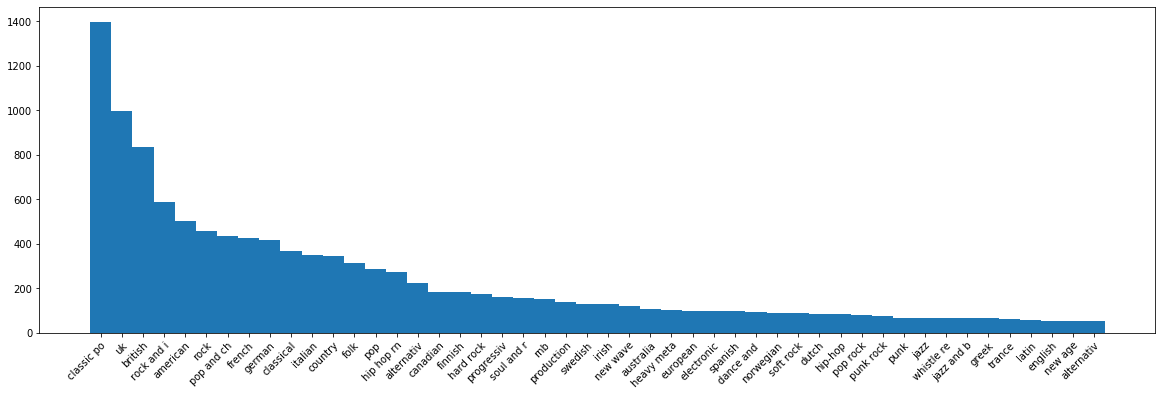

Distinct tag MBZ considered:


48

In [7]:
min_count = 50
data_filtered, tag_mbz_filtered = clean_and_filter(tag_mbz, min_count=min_count)

print('Distinct tag MBZ considered:')
len(np.unique(tag_mbz_filtered))

In [8]:
data_filtered, tag_mbz_filtered = extract_balanced(data_filtered, tag_mbz_filtered, min_count)

In [9]:
print('Total elements:')
len(data_filtered)

Total elements:


1440

In [10]:
labels_1hot = onehot_labels(tag_mbz_filtered)
    
onehot2str(labels_1hot[0])

'alternative metal'

In [11]:
data_filtered.shape

(1440, 100)

In [12]:
labels_1hot.shape

(1440, 48)

In [13]:
num_input = data_filtered.shape[1]
num_output = labels_1hot.shape[1]

num_input, num_output

(100, 48)

We use a Neural Network with 3 dense layers, trained with the Adam Optimizer.

In [14]:
def create_model():
    model = tf.keras.Sequential()
    
    model.add(layers.Dense(100, activation='relu', input_shape=(num_input,)))
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(num_output, activation='sigmoid'))

    model.compile(optimizer=tf.train.AdamOptimizer(0.01),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

In [15]:
neural_network = KerasClassifier(build_fn=create_model, 
                                 epochs=100, 
                                 batch_size=32, verbose=0)

The network is evaluated with 10-fold cross-validation. The final score is the average of the results.

In [16]:
random_state = 2111
scores = cross_val_score(neural_network, data_filtered, labels_1hot, 
                         cv=KFold(10, shuffle=True, random_state=random_state), verbose=0)
scores

W0827 17:21:56.695106 4799391168 deprecation.py:506] From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0827 17:21:56.854152 4799391168 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


array([0.97497106, 0.97786456, 0.97743058, 0.97641784, 0.97771996,
       0.97497106, 0.9765625 , 0.97887737, 0.97569442, 0.97771996])

In [17]:
np.mean(scores)

0.9768229305744172

In [18]:
predicted = cross_val_predict(neural_network, data_filtered, labels_1hot, 
                         cv=KFold(10, shuffle=True, random_state=random_state), verbose=0)

#### Confusion matrix, without normalization

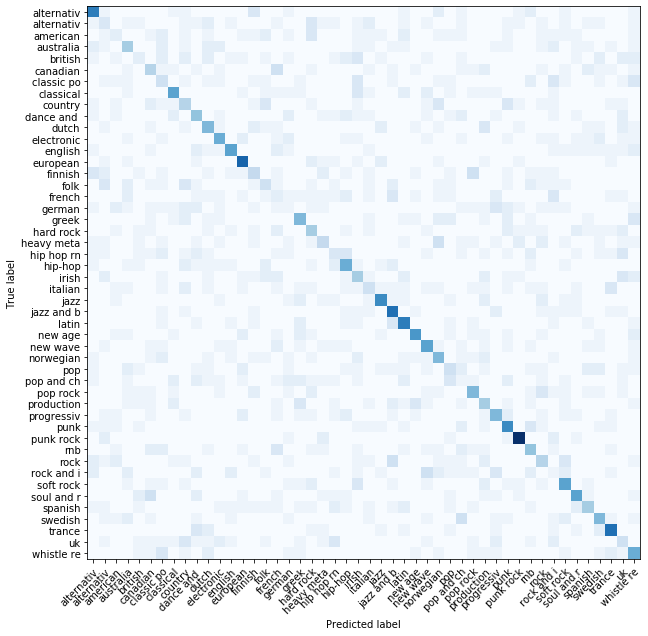

In [19]:
plot_confusion_matrix(labels_1hot, predicted, classes=tag_mbz_filtered, short='mbz')

#### Normalized confusion matrix

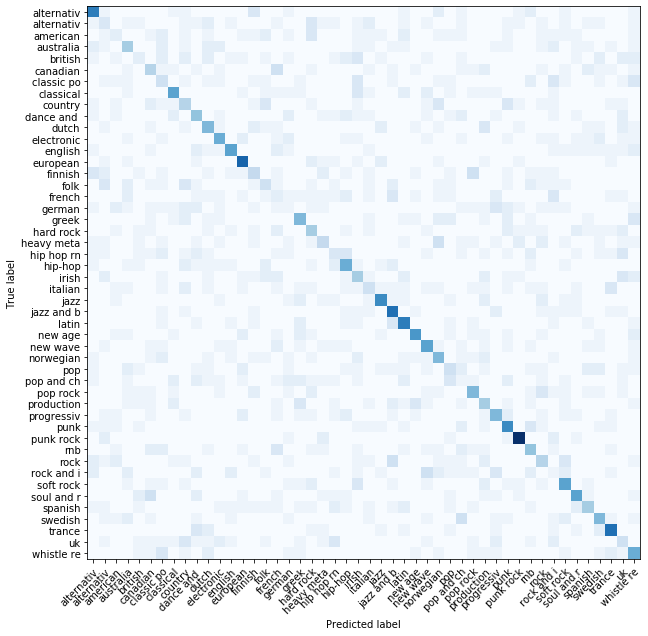

In [20]:
plot_confusion_matrix(labels_1hot, predicted, classes=tag_mbz_filtered, normalize=True, short='mbz')

### Experiment 2: Tag EchoNest 

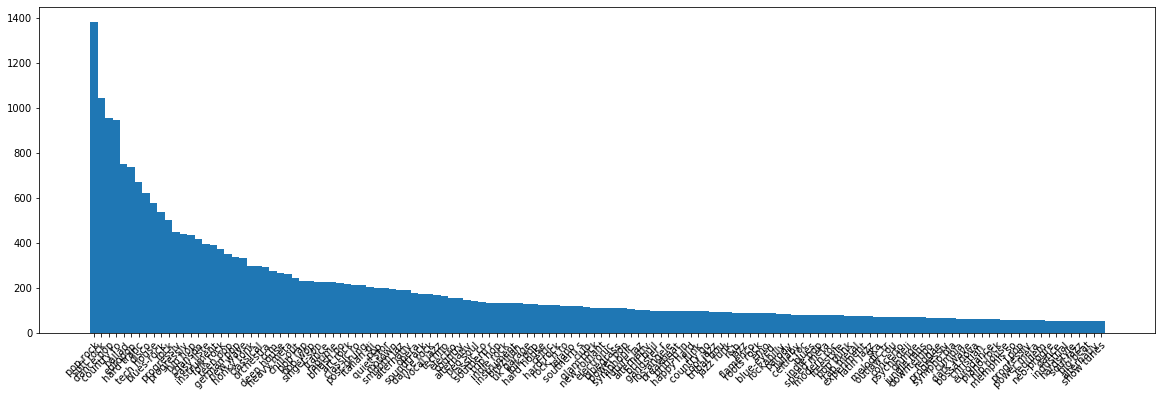

Distinct tag EchoNest considered:


136

In [21]:
data_filtered, tag_echo_filtered = clean_and_filter(tag_echo, min_count=min_count)

print('Distinct tag EchoNest considered:')
len(np.unique(tag_echo_filtered))

In [22]:
data_filtered, tag_echo_filtered = extract_balanced(data_filtered, tag_echo_filtered, min_count)

In [23]:
print('Total elements:')
len(data_filtered)

Total elements:


4080

In [24]:
labels_1hot = onehot_labels(tag_echo_filtered)
    
onehot2str(labels_1hot[0])

'alternative country'

In [25]:
num_output = labels_1hot.shape[1]

num_input, num_output

(100, 136)

In [26]:
neural_network = KerasClassifier(build_fn=create_model, 
                                 epochs=100, 
                                 batch_size=32,
                                 verbose = 0)

In [27]:
scores = cross_val_score(neural_network, data_filtered, labels_1hot, 
                         cv=KFold(10, shuffle=True, random_state=random_state), verbose=0)
scores

array([0.98855615, 0.98933107, 0.9897095 , 0.99077272, 0.98949319,
       0.98961937, 0.98927695, 0.98893464, 0.9890787 , 0.9897455 ])

In [28]:
np.mean(scores)

0.989451777935028

In [29]:
predicted = cross_val_predict(neural_network, data_filtered, labels_1hot, 
                         cv=KFold(10, shuffle=True, random_state=random_state), verbose=0)

#### Confusion matrix, without normalization

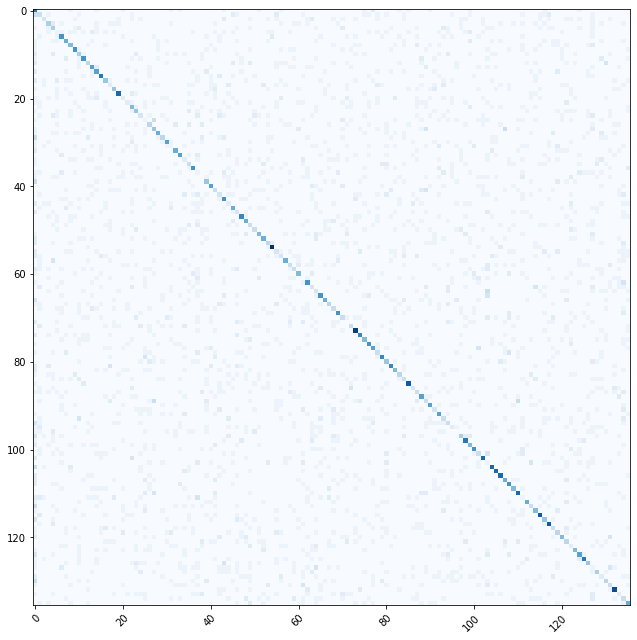

In [30]:
plot_confusion_matrix(labels_1hot, predicted, classes=tag_echo_filtered, short='echo')

#### Normalized confusion matrix

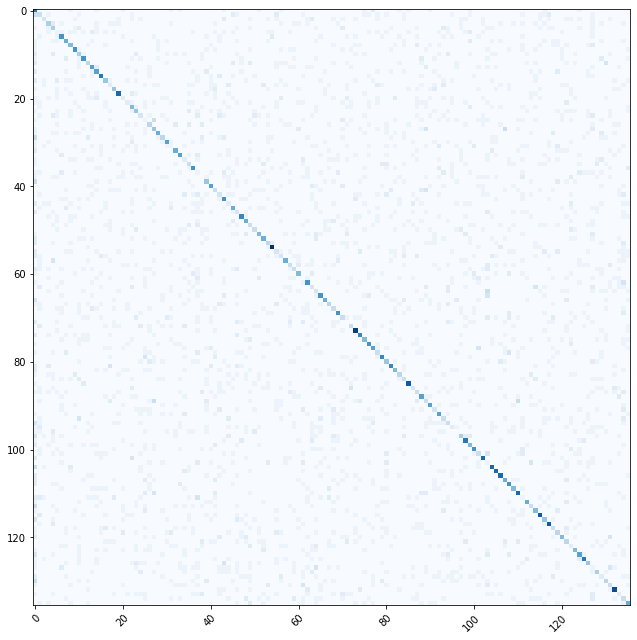

In [31]:
plot_confusion_matrix(labels_1hot, predicted, classes=tag_echo_filtered, normalize=True, short='echo')